Changelog:
1. Same as V11
2. stricter psuedo-label selection
3. training without english samples
4. triangular cyclical learning rates

# Settings

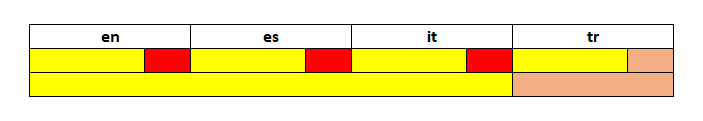

In [ ]:
# CONTROLS
MODEL_PREFIX = "V12"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

NUM_EPOCHS = [32, 32, 2]
NUM_FOLDS = 5
MIN_LR = 1e-6
MAX_LR = 1e-3
STEP_SIZE = 2
MAX_SEQ_LEN = 128
SAMPLE_SIZE = 6000
PSUEDO_QUANTILE_THRESH_HIGH = 0.98
PSUEDO_QUANTILE_THRESH_LOW = 0.02

RUN_ON_SAMPLE = 0
if RUN_ON_SAMPLE>0:
    SAMPLE_SIZE = RUN_ON_SAMPLE

ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 32
    PREDICT_BATCH_SIZE = 512
else:
    BATCH_SIZE = 16
    PREDICT_BATCH_SIZE = 256

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.1

In [ ]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".."
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    else:
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 987258
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Sun Jun 21 07:50:59 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [10]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [12]:
validation.lang.unique(), test.lang.unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([validation[REQ_COLS]], axis=0)

1. XLM-RoBerta uses these special tokens "sep_token": "\</s\>", "pad_token": "\<pad\>", "cls_token": "\<s\>"
2. Distilbert uses these special tokens "sep_token": "[SEP]", "pad_token": "[PAD]", "cls_token": "[CLS]"

In [17]:
languages = {
    'en':' english',
    'tr':' turkish',
    'ru':' russian',
    'it':' italian',
    'fr':' french',
    'pt':' portuguese',
    'es':' spanish',
}

if MODEL_NAME == 'xlm':
    data['text'] = data['lang'].apply(lambda x:languages[x]) + " </s> " + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x]) + " </s> " + test['text']
else:
    data['text'] = data['lang'].apply(lambda x:languages[x]) + " [SEP] " + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x]) + " [SEP] " + test['text']

In [18]:
data.shape

(8000, 5)

In [19]:
data.sample(2)

,id,set,text,lang,toxic
4153,4153,valid,turkish [SEP] İşte ben de diyorum ki Türkçede farklı bir ada sahip olmadığını iddia ediyorsanız muhtemelen konu ilgi alanınızda değil. Kişisel itham olarak algılamayın bir olasılık olarak söylüyorum. Konuya dair yakın dönem Türkçe hangi kaynağa bakarsanız bakın Kobane/Kobani görürsünüz. Kud yaz,tr,0
2736,2736,valid,"italian [SEP] Continuo anch io a pensare che la frase rispecchia perfettamente il pensiero di Odifreddi, che è quello di cui parla la voce su Odifreddi. Se la voce Adolf Hitler iniziasse con la citazione gli ebrei sono dei parassiti nel corpo delle altre nazioni ci sarebbero gli stessi problemi? .mau. ✉",it,0


In [20]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [21]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [22]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [23]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [24]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [25]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [26]:
X_tokens, X_att = [], []

for t in data.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens.append(encoded_text['input_ids'])
    X_att.append(encoded_text['attention_mask'])

X_tokens, X_att, X_lang, Y_toxic = np.array(X_tokens), np.array(X_att), data['lang'].values, data['toxic'].values

In [27]:
X_tokens_test, X_att_test = [], []

for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])
    
X_tokens_test, X_att_test, X_lang_test = np.array(X_tokens_test), np.array(X_att_test), test['lang'].values

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 128) 	: X_tokens_test  
 (63812, 128) 	: X_att_test  



In [28]:
print("**Sample Text**")
t = data['text'][0]
encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
decoded_tokens = xlmr_tok.decode(encoded_text['input_ids'])
print(t)
print("**Encoded Tokens**")
print(encoded_text['input_ids'], sep=",")
print("**Decoded Tokens**")
print(decoded_tokens)

**Sample Text**
 spanish [SEP] Este usuario ni siquiera llega al rango de    hereje   . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión.    Skipe linkin 22px   Honor, valor, leltad.      17:48 13 mar 2008 (UTC)
**Encoded Tokens**
[101, 51551, 15529, 102, 12515, 82849, 10414, 10294, 39190, 10113, 39492, 10164, 39715, 10104, 19353, 10381, 119, 12399, 10406, 12921, 96621, 10493, 29826, 11272, 10110, 10109, 18121, 10537, 83592, 10220, 32385, 66240, 10198, 39215, 193, 75036, 32500, 18010, 80592, 32413, 11244, 18229, 10198, 11600, 32413, 11482, 119, 51874, 11355, 26192, 10245, 10306, 10410, 10686, 26354, 117, 18094, 117, 10141, 92608, 119, 10273, 131, 11300, 10249, 12318, 10203, 113, 11780, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
**Decoded Tokens**
[CLS] spanish [SEP] Este usuario 

# Model Specifications

In [29]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR, config=config) # TFDistilBertForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    return model

In [30]:
model = build_model()

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 128)]        0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 768)     0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

# Cross Validation Strategy

KFold train-validation split

In [32]:
kf = KFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

KFold Stratified train-validation split

In [33]:
#skf = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

Leave one language out split

In [34]:
#logo = LeaveOneGroupOut()
#for t_index, v_index in logo.split(np.arange(X_tokens.shape[0]), np.arange(X_tokens.shape[0]), groups=X_lang):
#    print(X_lang[t_index])
#    #print(np.unique(X_lang[v_index]))

Simple random train-validation split

In [35]:
#t_index, v_index = train_test_split(np.arange(X_tokens.shape[0]), shuffle=True, random_state=seeded_value)

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [36]:
pred_df = data[['id']]
pred_df_test = test[['id']]
timings_dict = {}
cv_stats = {}

In [ ]:
for num, (t_index, v_index) in enumerate(kf.split(X_tokens, Y_toxic)):
    print("[INFO] ==================== FOLD#", num, "====================")
    
    start_time = time()

    if num>0:
        del model
        del mcp
        del csvl
        del adam
        del history
        del auc
        del tclr
        gc.collect()
        K.clear_session()

    model = build_model()
    auc = tf.keras.metrics.AUC(name='auc')
    mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5", monitor='val_auc',
                          verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
    csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+str(num)+".csv",
                     separator=",", append=True)
    tclr = tfa.optimizers.TriangularCyclicalLearningRate(
        initial_learning_rate=MIN_LR,
        maximal_learning_rate=MAX_LR,
        step_size=STEP_SIZE*len(t_index)
    )

    model.layers[2].trainable = False
    adam = Adam(learning_rate=tclr)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    train_time = time()
    history = model.fit(x={"att_flags":X_att[t_index],
                           "words":X_tokens[t_index]},
                        y={"toxic_output":Y_toxic[t_index]},
                        validation_data=({"att_flags":X_att[v_index],
                                          "words":X_tokens[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[0],
                        shuffle=True,
                        verbose=1, 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang[t_index]),
                        callbacks=[mcp, csvl])

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5")
    
    pred_initial = model.predict(x = {"att_flags":X_att,
                                      "words":X_tokens},
                                 batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['fold_'+str(num)] = 0
    pred_df['fold_'+str(num)].iloc[t_index] = 'train'
    pred_df['fold_'+str(num)].iloc[v_index] = 'valid'
    pred_df['initial_'+str(num)] = pred_initial
    
    roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index])
    roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index])
    acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0))
    acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0))
    
    print("Train ROC-AUC:\t", roc_t)
    print("Valid ROC-AUC:\t", roc_v)
    print("Train Accuracy:\t", acc_t)
    print("Valid Accuracy:\t", acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

    # Psuedo model fit
    psuedo_time = time()

    # Accumulate test results after training every fold
    pred_psuedo = model.predict(x = {"att_flags":X_att_test,
                                     "words":X_tokens_test},
                                batch_size=PREDICT_BATCH_SIZE).reshape((-1))

    pred_df_test['psuedo_'+str(num)] = pred_psuedo
    PSUEDO_PROB_THRESH_HIGH = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_HIGH)
    PSUEDO_PROB_THRESH_LOW = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_LOW)
    
    print("PSUEDO_PROB_THRESH_HIGH", np.round(PSUEDO_PROB_THRESH_HIGH,3))
    print("PSUEDO_PROB_THRESH_LOW", np.round(PSUEDO_PROB_THRESH_LOW,3))

    Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
    psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

    print("Number of psuedo samples available:", sum(psuedo_flag))
    print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
    print(Counter(test.lang.values))
    print(Counter(test.lang.values[psuedo_flag]))

    X_att_psuedo = np.concatenate((X_att[t_index], X_att_test[psuedo_flag]))
    X_tokens_psuedo = np.concatenate((X_tokens[t_index], X_tokens_test[psuedo_flag]))
    Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))
    X_lang_psuedo = np.concatenate((X_lang[t_index], X_lang_test[psuedo_flag]))

    shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
    np.random.shuffle(shuffled_idxs)

    model.layers[2].trainable = False
    adam = Adam(learning_rate=tclr)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                           "words":X_tokens_psuedo[shuffled_idxs]},
                        y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                        validation_data=({"att_flags":X_att[v_index],
                                          "words":X_tokens[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[1],
                        shuffle=True,
                        verbose=1,
                        callbacks=[mcp, csvl], 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang_psuedo[shuffled_idxs]))

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5")
    
    if NUM_EPOCHS[2]>0:
        model.layers[2].trainable = True
        adam = Adam(learning_rate=MIN_LR*0.1)
        model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                      optimizer=adam,
                      metrics=['accuracy', auc])

        history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                               "words":X_tokens_psuedo[shuffled_idxs]},
                            y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                            validation_data=({"att_flags":X_att[v_index],
                                              "words":X_tokens[v_index]},
                                             {"toxic_output":Y_toxic[v_index]}),
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS[2],
                            shuffle=True,
                            verbose=1,
                            callbacks=[mcp, csvl], 
                            sample_weight=class_weight.compute_sample_weight('balanced',X_lang_psuedo[shuffled_idxs]))

    infer_time = time()

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+".h5")

    pred = model.predict(x = {"att_flags":X_att,
                                    "words":X_tokens},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['final_'+str(num)] = pred

    final_roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index])
    final_roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index])
    final_acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0))
    final_acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0))    
    
    print("Train ROC-AUC:\t", final_roc_t)
    print("Valid ROC-AUC:\t", final_roc_v)
    print("Train Accuracy:\t", final_acc_t)
    print("Valid Accuracy:\t", final_acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

    # Accumulate test results after training every fold

    pred_test = model.predict(x = {"att_flags":X_att_test,
                                    "words":X_tokens_test},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df_test['final_'+str(num)] = pred_test

    end_time = time()
    timings_dict.update({num:{
        'start_time' : ctime(start_time),
        'train_time' : ctime(train_time),
        'infer_time' : ctime(infer_time),
        'psuedo_time' : ctime(psuedo_time),
        'end_time' : ctime(end_time),
    }})
    
    cv_stats.update({num:{
        'preliminary_roc_t':roc_t,
        'final_roc_t':final_roc_t,
        'preliminary_roc_v':roc_v,
        'final_roc_v':final_roc_v,
        'preliminary_acc_t':acc_t,
        'final_acc_t':final_acc_t,
        'preliminary_acc_v':acc_v,
        'final_acc_v':final_acc_v,
    }})

[INFO] ==================== FOLD# 0 ====================
  ...
    to  
  ['...']
Train on 6400 samples, validate on 1600 samples
Epoch 1/32
6400/6400 [==============================] - 47s 7ms/sample - loss: 0.6214 - accuracy: 0.7020 - auc: 0.5236 - val_loss: 0.4975 - val_accuracy: 0.8375 - val_auc: 0.5948
Epoch 2/32
6400/6400 [==============================] - 39s 6ms/sample - loss: 0.4903 - accuracy: 0.8334 - auc: 0.6508 - val_loss: 0.4585 - val_accuracy: 0.8487 - val_auc: 0.7176
Epoch 3/32
6400/6400 [==============================] - 39s 6ms/sample - loss: 0.4592 - accuracy: 0.8477 - auc: 0.7354 - val_loss: 0.4416 - val_accuracy: 0.8575 - val_auc: 0.7700
Epoch 4/32
6400/6400 [==============================] - 39s 6ms/sample - loss: 0.4454 - accuracy: 0.8505 - auc: 0.7765 - val_loss: 0.4338 - val_accuracy: 0.8619 - val_auc: 0.7867
Epoch 5/32
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.4371 - accuracy: 0.8572 - auc: 0.7980 - val_loss: 0.4324 - val_accuracy: 

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.

Train ROC-AUC:	 0.9417124259564248
Valid ROC-AUC:	 0.8431361845756344
Train Accuracy:	 0.89984375
Valid Accuracy:	 0.86375
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5413
           1       0.83      0.44      0.58       987

    accuracy                           0.90      6400
   macro avg       0.87      0.71      0.76      6400
weighted avg       0.89      0.90      0.89      6400

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1357
           1       0.61      0.29      0.39       243

    accuracy                           0.86      1600
   macro avg       0.75      0.63      0.66      1600
weighted avg       0.84      0.86      0.84      1600



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PSUEDO_PROB_THRESH_HIGH 0.766
PSUEDO_PROB_THRESH_LOW 0.002
Number of psuedo samples available: 2554
Psuedo Toxicity: 1277
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'pt': 1181, 'fr': 447, 'es': 445, 'tr': 199, 'it': 185, 'ru': 97})
  ...
    to  
  ['...']
Train on 8954 samples, validate on 1600 samples
Epoch 1/32
8954/8954 [==============================] - 66s 7ms/sample - loss: 0.3308 - accuracy: 0.9155 - auc: 0.9646 - val_loss: 0.4160 - val_accuracy: 0.8687 - val_auc: 0.8415
Epoch 2/32
8954/8954 [==============================] - 58s 6ms/sample - loss: 0.2997 - accuracy: 0.9165 - auc: 0.9642 - val_loss: 0.4108 - val_accuracy: 0.8675 - val_auc: 0.8406
Epoch 3/32
8954/8954 [==============================] - 59s 7ms/sample - loss: 0.2865 - accuracy: 0.9187 - auc: 0.9671 - val_loss: 0.4109 - val_accuracy: 0.8650 - val_auc: 0.8481
Epoch 4/32
8954/8954 [==============================] - 58s 6ms/sample - loss: 0.2886 - accuracy: 0.9208 -

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train ROC-AUC:	 0.9506499700241322
Valid ROC-AUC:	 0.84810660164791
Train Accuracy:	 0.910625
Valid Accuracy:	 0.865
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5413
           1       0.78      0.59      0.67       987

    accuracy                           0.91      6400
   macro avg       0.85      0.78      0.81      6400
weighted avg       0.90      0.91      0.91      6400

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1357
           1       0.58      0.41      0.48       243

    accuracy                           0.86      1600
   macro avg       0.74      0.68      0.70      1600
weighted avg       0.85      0.86      0.86      1600



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] ==================== FOLD# 1 ====================
  ...
    to  
  ['...']
Train on 6400 samples, validate on 1600 samples
Epoch 1/32
6400/6400 [==============================] - 46s 7ms/sample - loss: 0.5426 - accuracy: 0.7769 - auc: 0.6134 - val_loss: 0.4887 - val_accuracy: 0.8275 - val_auc: 0.7508
Epoch 2/32
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.4586 - accuracy: 0.8492 - auc: 0.7367 - val_loss: 0.4476 - val_accuracy: 0.8500 - val_auc: 0.7942
Epoch 3/32
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.4379 - accuracy: 0.8578 - auc: 0.7893 - val_loss: 0.4436 - val_accuracy: 0.8487 - val_auc: 0.7954
Epoch 4/32
6400/6400 [==============================] - 38s 6ms/sample - loss: 0.4297 - accuracy: 0.8580 - auc: 0.8132 - val_loss: 0.4465 - val_accuracy: 0.8512 - val_auc: 0.7932
Epoch 5/32
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.4210 - accuracy: 0.8672 - auc: 0.8285 - val_loss: 0.4451 - val_accuracy: 

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.9228388323251259
Valid ROC-AUC:	 0.8350933944933192
Train Accuracy:	 0.89515625
Valid Accuracy:	 0.848125
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5432
           1       0.75      0.46      0.57       968

    accuracy                           0.90      6400
   macro avg       0.83      0.72      0.76      6400
weighted avg       0.89      0.90      0.88      6400

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1338
           1       0.56      0.34      0.43       262

    accuracy                           0.85      1600
   macro avg       0.72      0.65      0.67      1600
weighted avg       0.83      0.85      0.83      1600



c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PSUEDO_PROB_THRESH_HIGH 0.78
PSUEDO_PROB_THRESH_LOW 0.008
Number of psuedo samples available: 2554
Psuedo Toxicity: 1277
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'pt': 695, 'es': 659, 'tr': 506, 'fr': 380, 'ru': 161, 'it': 153})
  ...
    to  
  ['...']
Train on 8954 samples, validate on 1600 samples
Epoch 1/32
8954/8954 [==============================] - 68s 8ms/sample - loss: 0.3133 - accuracy: 0.9132 - auc: 0.9574 - val_loss: 0.4621 - val_accuracy: 0.8481 - val_auc: 0.8390
Epoch 2/32
8954/8954 [==============================] - 60s 7ms/sample - loss: 0.2950 - accuracy: 0.9142 - auc: 0.9571 - val_loss: 0.4562 - val_accuracy: 0.8462 - val_auc: 0.8412
Epoch 3/32
8954/8954 [==============================] - 58s 7ms/sample - loss: 0.2929 - accuracy: 0.9174 - auc: 0.9561 - val_loss: 0.4311 - val_accuracy: 0.8544 - val_auc: 0.8403
Epoch 4/32
8954/8954 [==============================] - 59s 7ms/sample - loss: 0.2910 - accuracy: 0.9120 - 

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.937294346170936
Valid ROC-AUC:	 0.8424211310059926
Train Accuracy:	 0.9028125
Valid Accuracy:	 0.859375
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5416
           1       0.75      0.55      0.64       984

    accuracy                           0.90      6400
   macro avg       0.84      0.76      0.79      6400
weighted avg       0.90      0.90      0.90      6400

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1354
           1       0.56      0.39      0.46       246

    accuracy                           0.86      1600
   macro avg       0.73      0.67      0.69      1600
weighted avg       0.84      0.86      0.85      1600

PSUEDO_PROB_THRESH_HIGH 0.791
PSUEDO_PROB_THRESH_LOW 0.008
Number of psuedo samples available: 2554
Psuedo Toxicity: 1277
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'pt': 8

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.9484194647245849
Valid ROC-AUC:	 0.8416026436342812
Train Accuracy:	 0.90875
Valid Accuracy:	 0.871875
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5418
           1       0.90      0.46      0.61       982

    accuracy                           0.91      6400
   macro avg       0.90      0.72      0.78      6400
weighted avg       0.91      0.91      0.90      6400

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1352
           1       0.72      0.28      0.41       248

    accuracy                           0.87      1600
   macro avg       0.80      0.63      0.67      1600
weighted avg       0.86      0.87      0.85      1600

PSUEDO_PROB_THRESH_HIGH 0.839
PSUEDO_PROB_THRESH_LOW 0.016
Number of psuedo samples available: 2554
Psuedo Toxicity: 1277
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'tr': 81

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train ROC-AUC:	 0.9532865581745419
Valid ROC-AUC:	 0.8552613687748823
Train Accuracy:	 0.9153125
Valid Accuracy:	 0.876875
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5401
           1       0.82      0.58      0.68       999

    accuracy                           0.92      6400
   macro avg       0.87      0.78      0.82      6400
weighted avg       0.91      0.92      0.91      6400

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1369
           1       0.60      0.43      0.50       231

    accuracy                           0.88      1600
   macro avg       0.76      0.69      0.72      1600
weighted avg       0.86      0.88      0.87      1600

PSUEDO_PROB_THRESH_HIGH 0.79
PSUEDO_PROB_THRESH_LOW 0.013
Number of psuedo samples available: 2554
Psuedo Toxicity: 1277
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'tr': 6

In [ ]:
pd.DataFrame.from_dict(timings_dict).head(25)

In [ ]:
pd.DataFrame.from_dict(cv_stats)

# Outputs

In [ ]:
pred_df['toxic_pred'] = pred_df[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)
pred_df_test['toxic'] = pred_df_test[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)

In [ ]:
pred_df_test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)
pred_df_test.to_csv(RESULTS_DIR+"all_test_results_"+MODEL_PREFIX+".csv", index=False)
pred_df.to_csv(RESULTS_DIR+"all_results_"+MODEL_PREFIX+".csv", index=False)

# Output Analysis

In [ ]:
lang_group = pd.concat((data, pred_df), axis=1).groupby(['lang'])
lang_group[['toxic','toxic_pred']].apply(lambda x: pd.Series({'roc':roc_auc_score(y_true=x.toxic,
                                                                                  y_score=x.toxic_pred), 
                                                              'acc':accuracy_score(y_true=np.round(x.toxic),
                                                                                   y_pred=np.round(x.toxic_pred).astype(int))})).reset_index()

In [ ]:
pred_df_test['toxic'].describe()

In [ ]:
pred_df_test.groupby(test['lang'])[['toxic']].apply(pd.Series.describe)

In [ ]:
print(ctime(time()))